From my github: https://github.com/smartdanny/imagenette_starter

In [1]:
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
import os
import tarfile
import hashlib

# https://github.com/fastai/imagenette

#choose image sizes:
datasets = {
    'full_sz': 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz', # 1.5GB
    '320px': 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz', # 326mb
    '160px': 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz' # 94mb
}


dataset_url = datasets['full_sz']

dataset_filename = dataset_url.split('/')[-1]
dataset_foldername = dataset_filename.split('.')[0]
data_path = '../imagenette_data'
dataset_filepath = os.path.join(data_path,dataset_filename)
dataset_folderpath = os.path.join(data_path,dataset_foldername)

os.makedirs(data_path, exist_ok=True)

download = False
if not os.path.exists(dataset_filepath):
    download = True
else:
    md5_hash = hashlib.md5()


    file = open(dataset_filepath, "rb")

    content = file.read()

    md5_hash.update(content)


    digest = md5_hash.hexdigest()
    if digest != 'fe2fc210e6bb7c5664d602c3cd71e612':
        download = True
if download:
    torchvision.datasets.utils.download(dataset_url, data_path)

with tarfile.open(dataset_filepath, 'r:gz') as tar:
    tar.extractall(path=data_path)
    

In [3]:
TRAIN_DIR = os.path.join(dataset_folderpath,'train')
TEST_DIR = os.path.join(dataset_folderpath,'val')

In [4]:
from src.data_stuff import dataset_tools

In [5]:
rgb_mean = (0.4914, 0.4822, 0.4465)
rgb_std = (0.2023, 0.1994, 0.2010)
train_tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    # torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(rgb_mean, rgb_std),
])
test_tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(rgb_mean, rgb_std),
])


# dataset_train = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'train'), train_tfms)
# dataset_valid = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'val'), test_tfms)
dataset_train = dataset_tools.ImageFolderWithPaths(TRAIN_DIR, train_tfms)
dataset_valid = dataset_tools.ImageFolderWithPaths(TEST_DIR, test_tfms)

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=batch_size,
        num_workers=6,
        drop_last=True,
        shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
        dataset_valid,
        batch_size=batch_size,
        num_workers=6,
        drop_last=True,
        shuffle=True,
)

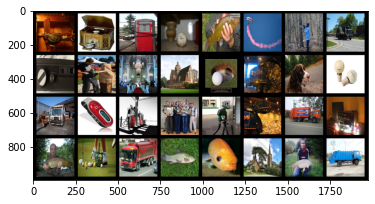

In [6]:
images = next(iter(train_dataloader))[1]
plt.imshow(torchvision.utils.make_grid(images, padding=20).permute(1, 2, 0))

# Model

In [7]:
from pytorch_lightning import LightningModule, Trainer
import torchvision.models as models

# MY local imports
from src.callback_stuff import LogConfusionMatrix
from src.model_stuff import MyResNet

In [8]:
model = MyResNet.MyResNet(num_classes=10)
trainer = Trainer(gpus=1, max_epochs=15, callbacks=[LogConfusionMatrix.LogConfusionMatrix(num_classes=10)])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Logging Confusion Mat initialized


In [ ]:
trainer.fit(model, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

/home/shatz/miniconda3/envs/moti/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:531: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type    | Params
-------------------------------------
0 | model    | ResNet  | 11.2 M
1 | criteria | BCELoss | 0     
-------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/shatz/miniconda3/envs/moti/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:372: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

/home/shatz/miniconda3/envs/moti/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:397: LightningDeprecationWarning: One of the returned values {'batch_outputs', 'acc'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]